# System Statues Check

In [2]:
import torch
print(torch.__version__)
import psutil

def print_system_usage():
    # 获取 CPU 信息
    cpu_count = psutil.cpu_count(logical=True)
    cpu_usage = psutil.cpu_percent()
    
    # 获取内存信息
    memory_info = psutil.virtual_memory()
    total_memory_gb = memory_info.total / 1024 ** 3
    used_memory_gb = memory_info.used / 1024 ** 3
    memory_usage_percent = memory_info.percent

    # 获取 GPU 信息
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        cuda_capability = torch.cuda.get_device_capability(0)
        gpu_memory_total = torch.cuda.get_device_properties(0).total_memory / 1024 ** 3
        gpu_memory_used = torch.cuda.memory_allocated(0) / 1024 ** 3
        gpu_memory_usage_percent = (gpu_memory_used / gpu_memory_total) * 100
        gpu_info = f"{gpu_name}, CUDA {cuda_capability[0]}.{cuda_capability[1]}, {gpu_memory_used:.2f}/{gpu_memory_total:.2f} GB ({gpu_memory_usage_percent:.1f}%)"
    else:
        gpu_info = "No GPU available"

    # 打印系统信息在一行
    print(f"CPU: {cpu_count} cores, {cpu_usage}% | RAM: {used_memory_gb:.2f}/{total_memory_gb:.2f} GB ({memory_usage_percent}%) | GPU: {gpu_info}")

# 调用函数
print_system_usage()


2.3.0+cu121
CPU: 32 cores, 3.7% | RAM: 8.87/125.48 GB (9.0%) | GPU: NVIDIA RTX A5000, CUDA 8.6, 0.00/23.68 GB (0.0%)


# Database

In [3]:
import os
import sqlite3

# 定义数据库路径和数据文件夹路径
db_path = 'patient_data.db'
full_dataset_path = '/media/molloi-lab-linux2/HD-88/ICONIC CCTAS'  # 替换为实际路径
subset_path = '/home/molloi-lab-linux2/Desktop/ZQY/shant2'       # 替换为实际路径

# 检查数据库是否已存在
if os.path.exists(db_path):
    print(f"数据库 '{db_path}' 已存在。")
    
    # 连接到现有数据库并打印基础信息
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # 检查表是否存在以及基础信息
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='patient_data'")
    table_exists = cursor.fetchone()
    
    if table_exists:
        print("数据库中已包含表 'patient_data'。")
        
        # 获取表结构信息
        cursor.execute("PRAGMA table_info(patient_data)")
        columns = cursor.fetchall()
        print("表结构:")
        for column in columns:
            print(f" - {column[1]} ({column[2]})")
        
        # 打印表中已有的记录数
        cursor.execute("SELECT COUNT(*) FROM patient_data")
        record_count = cursor.fetchone()[0]
        print(f"表 'patient_data' 中已有记录数: {record_count}")
    else:
        print("数据库存在，但未找到表 'patient_data'。")
    
    # 关闭数据库连接
    conn.close()
else:
    # 如果数据库不存在，创建一个新的数据库和表结构
    print(f"数据库 '{db_path}' 不存在，正在创建新数据库并初始化数据...")
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # 创建表结构，新增字段
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS patient_data (
            -- 文件属性
            id INTEGER PRIMARY KEY AUTOINCREMENT,     -- 每条记录的唯一标识符，自增主键
            patient_id TEXT,                          -- 患者 ID，从文件夹名获取，用于识别患者
            nii_path TEXT,                            -- .nii 文件的路径，用于定位具体文件
                   
            -- 标记结果
            contrast_type TEXT,                       -- 对比类型 ("Contrast", "Uncontrast", "Mid")，初始时留空
            contrast_level REAL,                      -- 对比度等级 (0-1)，表示对比强度，初始时留空
            usable_slices TEXT,                       -- 可用于训练的切片编号，以逗号分隔的字符串形式存储
            usable_for_training TEXT,                 -- 是否用于训练 ("Yes", "No", "Partial")，初始时留空
            in_subset TEXT,                           -- 标记文件是否在子数据集 (shant2) 中 ("Yes" 或 "No")
            
            -- 标记过程用字段
            is_discarded TEXT,                        -- 是否弃用数据 ("Yes" 或 "No")，默认值为 "No"
            manual_contrast_type TEXT,                -- 手动分类的对比类型 ("contrast", "non contrast", "mid")，用户手动指定
            brightness_contrast_type TEXT,            -- 基于亮度值的对比分类 ("contrast", "non contrast", "mid")，用于记录自动分类结果
            brightness_max REAL,                      -- 亮度最大值，记录图像数据中的最大亮度值
            brightness_min REAL,                      -- 亮度最小值，记录图像数据中的最小亮度值
            brightness_avg REAL                       -- 亮度平均值，记录图像数据中的平均亮度值
        )
    ''')
    conn.commit()
    
    # 遍历 shant 文件夹，初始化数据库条目
    for patient_folder in os.listdir(full_dataset_path):
        patient_path = os.path.join(full_dataset_path, patient_folder)
        
        if os.path.isdir(patient_path):
            patient_id = patient_folder  # 用文件夹名作为患者 ID
            
            for nii_file in os.listdir(patient_path):
                if nii_file.endswith(".nii"):
                    nii_path = os.path.join(patient_path, nii_file)
                    
                    # 检查该 .nii 文件是否也在 shant2 子数据集中
                    relative_nii_path = os.path.relpath(nii_path, full_dataset_path)
                    in_subset = "Yes" if os.path.exists(os.path.join(subset_path, relative_nii_path)) else "No"
                    
                    # 插入新的条目到数据库，初始属性值留空或设为默认
                    cursor.execute('''
                        INSERT INTO patient_data (
                            patient_id, nii_path, contrast_type, contrast_level, usable_slices,
                            usable_for_training, in_subset, is_discarded, manual_contrast_type, 
                            brightness_contrast_type, brightness_max, brightness_min, brightness_avg
                        )
                        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    ''', (patient_id, nii_path, None, None, None, None, in_subset, "No", None, None, None, None, None))
    
    conn.commit()
    print("新数据库和表 'patient_data' 已创建，并已从 'shant' 文件夹初始化数据。")
    
    # 关闭数据库连接
    conn.close()


数据库 'patient_data.db' 已存在。
数据库存在，但未找到表 'patient_data'。


# Select Training Data

## Brightness Classification

In [6]:
import os
import sqlite3
import SimpleITK as sitk
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock


# 连接到数据库
conn = sqlite3.connect(db_path, check_same_thread=False)  # 多线程模式下需要设置 check_same_thread=False
cursor = conn.cursor()

# 获取数据库中的所有 .nii 文件路径
cursor.execute("SELECT id, patient_id, nii_path FROM patient_data")
records = cursor.fetchall()
total_files = len(records)  # 总文件数

# 锁，用于线程间同步数据库写入
lock = Lock()

def process_file(record):
    """处理每个 .nii 文件，计算亮度信息并更新数据库"""
    record_id, patient_id, nii_path = record
    if os.path.exists(nii_path):
        try:
            # 加载 .nii 文件
            img = sitk.ReadImage(nii_path)
            data = sitk.GetArrayFromImage(img)  # 转换为 NumPy 数组
            
            # 计算亮度统计信息
            brightness_max = np.max(data)
            brightness_min = np.min(data)
            brightness_avg = np.mean(data)
            
            # 更新数据库中的亮度信息（使用锁来确保数据库操作的线程安全）
            with lock:
                cursor.execute('''
                    UPDATE patient_data
                    SET brightness_max = ?, brightness_min = ?, brightness_avg = ?
                    WHERE id = ?
                ''', (brightness_max, brightness_min, brightness_avg, record_id))
                conn.commit()
            
            return f"已更新亮度信息: {patient_id} - {nii_path}"
        
        except Exception as e:
            return f"处理文件 {nii_path} 时出错: {e}"
    else:
        return f"文件不存在: {nii_path}"

# 处理进度显示
def show_progress(futures):
    completed = 0
    for future in as_completed(futures):
        print(future.result())  # 输出每个任务的结果
        completed += 1
        progress = (completed / total_files) * 100
        print(f"进度: {progress:.2f}% ({completed}/{total_files})")

# 使用 ThreadPoolExecutor 进行多线程处理
with ThreadPoolExecutor(max_workers=5) as executor:  # 设置线程数量，建议根据 CPU 核心数选择适当数量
    futures = [executor.submit(process_file, record) for record in records]
    show_progress(futures)

# 关闭数据库连接
conn.close()
print("所有亮度信息已更新。")


已更新亮度信息: Confirm_7759 - /home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/0.nii
进度: 0.03% (1/3350)
已更新亮度信息: Confirm_7759 - /home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/12.nii
进度: 0.06% (2/3350)
已更新亮度信息: Confirm_7759 - /home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/6.nii
进度: 0.09% (3/3350)
已更新亮度信息: Confirm_7759 - /home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/3.nii
进度: 0.12% (4/3350)
已更新亮度信息: Confirm_7759 - /home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/2.nii
进度: 0.15% (5/3350)
已更新亮度信息: Confirm_7759 - /home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/10.nii
进度: 0.18% (6/3350)
已更新亮度信息: Confirm_7759 - /home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/7.nii
进度: 0.21% (7/3350)
已更新亮度信息: Confirm_7759 - /home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/14.nii
进度: 0.24% (8/3350)
已更新亮度信息: Confirm_7759 - /home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/13.nii
进度: 0.27% (9/3350)
已更新亮度信息: Confirm_7759 - /home/molloi-lab-linux2/Desktop/ZQY/

# Train Model

In [19]:
import os
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import numpy as np
from sklearn.cluster import KMeans
from torch.nn.functional import interpolate
from tqdm import tqdm

# 设置设备为 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



# 定义数据库路径
db_path = 'patient_data.db'

# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=3, stride=2, padding=1),  # 输入5个通道（5张切片）
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 5, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # 使用 interpolate 将输出调整到 (5, 50, 50)
        decoded = nn.functional.interpolate(decoded, size=(50, 50), mode="bilinear", align_corners=False)
        return encoded, decoded

# 定义数据集类
class NiiDataset(Dataset):
    def __init__(self, nii_files):
        self.nii_files = nii_files

    def __len__(self):
        return len(self.nii_files)

    def __getitem__(self, idx):
        # 加载 .nii 文件并均匀提取 5 张切片
        nii_file = self.nii_files[idx]
        img = sitk.ReadImage(nii_file)
        data = sitk.GetArrayFromImage(img)  # 转换为 NumPy 数组 (depth, height, width)
        
        num_slices = data.shape[0]
        indices = np.linspace(0, num_slices - 1, 5, dtype=int)  # 均匀选择 5 张切片
        slices = data[indices, :, :]  # 提取切片

        # 将每张切片缩放到 50x50 并归一化
        slices_resized = []
        for slice_img in slices:
            slice_img_resized = interpolate(
                torch.tensor(slice_img).unsqueeze(0).unsqueeze(0).float(), 
                size=(50, 50), 
                mode='bilinear', 
                align_corners=False
            ).squeeze(0).squeeze(0)
            slices_resized.append(slice_img_resized)
        
        slices_resized = torch.stack(slices_resized)  # 组合为 (5, 50, 50)
        return slices_resized

# 从数据库提取 .nii 文件路径
def load_nii_files_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT nii_path FROM patient_data")
    records = cursor.fetchall()
    conn.close()
    nii_files = [record[0] for record in records if os.path.exists(record[0])]
    return nii_files

# 训练自编码器，带有进度显示
def train_autoencoder(dataloader, model, epochs=10, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]", unit="batch")
        
        for data in progress_bar:
            # 将数据传输到 GPU
            data = data.to(device)
            
            optimizer.zero_grad()
            inputs = data
            _, outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})
        
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}")

# 聚类和分类
def cluster_features(dataloader, model):
    model.eval()
    features = []
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)  # 将数据传输到 GPU
            encoded, _ = model(data)
            features.append(encoded.view(encoded.size(0), -1))  # 展平特征
    features = torch.cat(features).cpu().numpy()  # 将特征转为 NumPy 数组

    # 使用 K-means 聚类
    kmeans = KMeans(n_clusters=2, random_state=0)
    labels = kmeans.fit_predict(features)
    return labels

# 主流程
nii_files = load_nii_files_from_db(db_path)
dataset = NiiDataset(nii_files)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 初始化并训练模型

autoencoder = Autoencoder().to(device)
train_autoencoder(dataloader, autoencoder, epochs=10, learning_rate=1e-3)

# 聚类并输出分类结果
labels = cluster_features(dataloader, autoencoder)
for i, label in enumerate(labels):
    print(f"{nii_files[i]} -> 类别: {label}")


Using device: cuda


Epoch [1/10]:   0%|          | 0/3350 [00:00<?, ?batch/s, Loss=4.57e+5]

Epoch [1/10]:   1%|▏         | 42/3350 [00:06<08:22,  6.58batch/s, Loss=3.74e+5]


KeyboardInterrupt: 

In [25]:
import os
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import SimpleITK as sitk
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 从数据库中加载 .nii 文件路径
def load_nii_paths_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT nii_path FROM patient_data")
    records = cursor.fetchall()
    conn.close()
    
    # 提取有效文件路径
    nii_files = [record[0] for record in records if os.path.exists(record[0])]
    return nii_files

# 定义数据集类，用于加载和预处理 .nii 数据
class NiiDataset(Dataset):
    def __init__(self, nii_files, target_shape=(50, 50), num_slices=5):
        self.nii_files = nii_files
        self.target_shape = target_shape
        self.num_slices = num_slices

    def __len__(self):
        return len(self.nii_files)

    def __getitem__(self, idx):
        nii_file = self.nii_files[idx]
        img = sitk.ReadImage(nii_file)
        img_array = sitk.GetArrayFromImage(img)  # (depth, height, width)
        
        # 均匀提取 num_slices 张切片并缩放至 target_shape
        num_total_slices = img_array.shape[0]
        indices = np.linspace(0, num_total_slices - 1, self.num_slices, dtype=int)
        slices = img_array[indices]
        
        # 添加 defaultPixelValue 参数
        slices_resized = [
            np.array(sitk.GetArrayFromImage(
                sitk.Resample(
                    sitk.GetImageFromArray(slice_img),
                    sitk.Transform(),
                    sitk.sitkLinear,
                    defaultPixelValue=0.0,
                    outputPixelType=sitk.sitkFloat32,
                    size=self.target_shape
                )
            )) for slice_img in slices
        ]
        
        # 归一化
        slices_resized = np.stack(slices_resized).astype('float32')
        slices_resized = (slices_resized - np.min(slices_resized)) / (np.max(slices_resized) - np.min(slices_resized))
        
        # 将切片展平为一维向量
        return torch.tensor(slices_resized.flatten(), dtype=torch.float32)


# 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self, original_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(original_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, original_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc2_mean(h1), self.fc2_logvar(h1)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# VAE 损失函数
def vae_loss(recon_x, x, mean, logvar):
    reconstruction_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# 主流程
db_path = "patient_data.db"
nii_files = load_nii_paths_from_db(db_path)
dataset = NiiDataset(nii_files)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型和优化器
original_dim = 50 * 50 * 5
hidden_dim = 128
latent_dim = 2
model = VAE(original_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练 VAE
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mean, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mean, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader.dataset):.4f}")

# 提取潜在空间表示
model.eval()
with torch.no_grad():
    latents = []
    for batch in dataloader:
        batch = batch.to(device)
        mean, logvar = model.encode(batch)
        latents.append(mean.cpu().numpy())
    latents = np.concatenate(latents)

# 可视化潜在空间
plt.figure(figsize=(8, 6))
plt.scatter(latents[:, 0], latents[:, 1])
plt.colorbar()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Representation")
plt.show()


/tmp/ipykernel_781988/639494072.py:60: RuntimeWarning: invalid value encountered in true_divide
  slices_resized = (slices_resized - np.min(slices_resized)) / (np.max(slices_resized) - np.min(slices_resized))


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [35]:
import os
import numpy as np
import SimpleITK as sitk
import sqlite3
from skimage.metrics import structural_similarity as ssim
from concurrent.futures import ThreadPoolExecutor
import cv2

# 从数据库中加载 .nii 文件路径
def load_nii_paths_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT nii_path FROM patient_data")
    records = cursor.fetchall()
    conn.close()
    
    nii_files = [record[0] for record in records if os.path.exists(record[0])]
    return nii_files

# 添加 similarity 列
def add_similarity_column(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("PRAGMA table_info(patient_data)")
    columns = [column[1] for column in cursor.fetchall()]
    if 'similarity' not in columns:
        cursor.execute("ALTER TABLE patient_data ADD COLUMN similarity REAL")
    conn.commit()
    conn.close()

# 加载基准切片
def load_reference_slice(reference_path, slice_index=43, target_shape=(100, 100)):
    reference_img = sitk.ReadImage(reference_path)
    reference_data = sitk.GetArrayFromImage(reference_img)
    
    # 获取指定的切片，并调整大小
    reference_slice = reference_data[slice_index]
    reference_resized = cv2.resize(reference_slice, target_shape, interpolation=cv2.INTER_LINEAR)
    return reference_resized

# 计算与基准切片的最大相似度
def calculate_max_similarity_with_reference(nii_path, reference_slice, target_shape=(100, 100), num_slices=10):
    img = sitk.ReadImage(nii_path)
    img_data = sitk.GetArrayFromImage(img)
    num_slices_total = img_data.shape[0]
    
    # 均匀提取 num_slices 张切片并调整大小
    indices = np.linspace(0, num_slices_total - 1, num_slices, dtype=int)
    img_slices = img_data[indices]
    img_resized_slices = [
        cv2.resize(slice_img, target_shape, interpolation=cv2.INTER_LINEAR)
        for slice_img in img_slices
    ]
    
    # 计算每张切片与基准切片的 SSIM，取最大值
    ssim_values = [
        ssim(img_slice, reference_slice, data_range=img_slice.max() - img_slice.min())
        for img_slice in img_resized_slices
    ]
    return max(ssim_values)

# 写入数据库
def write_similarity_to_db(db_path, nii_path, similarity):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("UPDATE patient_data SET similarity = ? WHERE nii_path = ?", (similarity, nii_path))
    conn.commit()
    conn.close()

# 并行任务
def process_file(nii_path):
    similarity = calculate_max_similarity_with_reference(nii_path, reference_slice, target_shape=target_shape, num_slices=num_slices)
    write_similarity_to_db(db_path, nii_path, similarity)
    print(f"{nii_path} 的相似性为: {similarity:.4f}")

# 主流程
db_path = "patient_data.db"
reference_path = "/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_19074/23.nii"
slice_index = 43
target_shape = (100, 100)
num_slices = 10

# 添加数据库列
add_similarity_column(db_path)

# 加载基准文件的指定切片
reference_slice = load_reference_slice(reference_path, slice_index=slice_index, target_shape=target_shape)

# 加载数据库中的 .nii 文件路径
nii_files = load_nii_paths_from_db(db_path)

# 使用 ThreadPoolExecutor 并行处理
with ThreadPoolExecutor(max_workers=32) as executor:
    executor.map(process_file, nii_files)

print("所有相似性数据已写入数据库。")


/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_34206/3.nii 的相似性为: 0.1271
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_18437/4.nii 的相似性为: 0.0714
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/11.nii 的相似性为: 0.0618
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_34206/6.nii 的相似性为: 0.0688
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/12.nii 的相似性为: 0.0675
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_33494/6.nii 的相似性为: 0.1322
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_18437/3.nii 的相似性为: 0.0553
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_34206/5.nii 的相似性为: 0.1112
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/5.nii 的相似性为: 0.0700
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/4.nii 的相似性为: 0.0760
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_34206/2.nii 的相似性为: 0.0283
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_18437/2.nii 的相似性为: 0.0457
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_7759/14.nii 的相似性为: 0.1321
/home/molloi-l

/tmp/ipykernel_781988/2064949669.py:57: RuntimeWarning: overflow encountered in short_scalars
  ssim(img_slice, reference_slice, data_range=img_slice.max() - img_slice.min())


/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_8428/1.nii 的相似性为: 0.1244
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_50756/0.nii 的相似性为: 0.4217
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_50756/1.nii 的相似性为: 0.5022
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_8428/0.nii 的相似性为: 0.1742
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_10149/11.nii 的相似性为: 0.0449
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_20050/4.nii 的相似性为: 0.0743
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_10069/2.nii 的相似性为: 0.1019
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_12241/8.nii 的相似性为: 0.0449
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_21499/4.nii 的相似性为: 0.0484
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_53794/0.nii 的相似性为: 0.0994
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_33451/3.nii 的相似性为: 0.0566
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_10149/1.nii 的相似性为: 0.0946
/home/molloi-lab-linux2/Desktop/ZQY/shant/Confirm_21499/3.nii 的相似性为: 0.0504
/home/molloi-

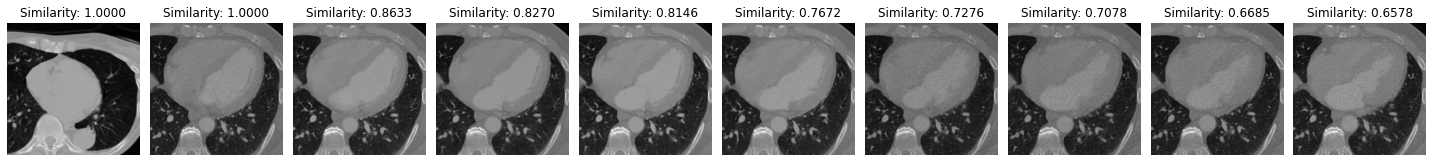

In [38]:
import os
import numpy as np
import SimpleITK as sitk
import sqlite3
import matplotlib.pyplot as plt

# 从数据库中按相似度从高到低提取 .nii 文件路径
def load_sorted_nii_paths(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT nii_path, similarity FROM patient_data ORDER BY similarity DESC")
    records = cursor.fetchall()
    conn.close()
    return records  # 返回 [(路径, 相似度), ...]

# 加载 .nii 文件的一个均匀抽样的切片，保持原始分辨率
def load_sample_slice(nii_path, num_slices=10):
    img = sitk.ReadImage(nii_path)
    img_data = sitk.GetArrayFromImage(img)
    num_slices_total = img_data.shape[0]
    
    # 均匀提取 num_slices 张切片中的一张
    slice_index = num_slices_total // 2  # 选取中间切片
    sample_slice = img_data[slice_index]
    return sample_slice

# 展示相似度排序后的切片图像
def display_slices(sorted_records, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for i, (nii_path, similarity) in enumerate(sorted_records[:num_samples]):
        sample_slice = load_sample_slice(nii_path)
        
        # 显示切片
        ax = axes[i]
        ax.imshow(sample_slice, cmap="gray")
        ax.set_title(f"Similarity: {similarity:.4f}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# 主流程
db_path = "patient_data.db"
num_samples = 10  # 展示前 10 个相似度最高的切片

# 获取按相似度排序的 .nii 文件路径
sorted_records = load_sorted_nii_paths(db_path)

# 展示切片
display_slices(sorted_records, num_samples=num_samples)


# Validation

# Handle Data